# Reproduction Number

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.dates as mdates
from datetime import datetime
import seaborn as sns; sns.set()
import warnings
warnings.filterwarnings('ignore')
from platform import python_version
print("python version: %s"%python_version())
print("numpy version: %s"%np.__version__)
print("pandas version: %s"%pd.__version__)
print("matplotlib version: %s"%mpl.__version__)

python version: 3.8.2
numpy version: 1.18.1
pandas version: 1.0.2
matplotlib version: 3.3.1


In [2]:
#url_confirmed = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv"
url_confirmed = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
confirmed_dataset = pd.read_csv(url_confirmed) 
#url_deaths = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv"
url_deaths = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
deaths_dataset = pd.read_csv(url_deaths)
# creates an index of dates
start_date_index = 43 # starts from March 1st
end_date_index = len(confirmed_dataset.columns) 
start_day = pd.to_datetime(confirmed_dataset.columns[start_date_index]).strftime('%Y-%m-%d')
end_day = pd.to_datetime(confirmed_dataset.columns[end_date_index - 1]).strftime('%Y-%m-%d')
date_index = pd.date_range(start_day, end_day)
week_index = pd.date_range(start_day, end_day, freq='W')
date_index_array = [date.strftime('%Y-%m-%d') for date in date_index] # dates array used for plotting

In [3]:
confirmed_dataset_it = confirmed_dataset[confirmed_dataset['Country/Region'] == 'Italy']
confirmed_dataset_values_it = [confirmed for confirmed in confirmed_dataset_it.values[0][start_date_index:]] 
confirmed_infections_it = pd.Series(confirmed_dataset_values_it, index=date_index)
confirmed_infections_it['2020-10-01':]

2020-10-01    317409
2020-10-02    319908
2020-10-03    322751
2020-10-04    325329
2020-10-05    327586
2020-10-06    330263
2020-10-07    333940
2020-10-08    338398
2020-10-09    343770
2020-10-10    349494
2020-10-11    354950
2020-10-12    359569
2020-10-13    365467
2020-10-14    372799
2020-10-15    381602
2020-10-16    391611
2020-10-17    402536
2020-10-18    414241
2020-10-19    423578
2020-10-20    434449
2020-10-21    449648
2020-10-22    465726
2020-10-23    484869
2020-10-24    504509
2020-10-25    525782
2020-10-26    542789
2020-10-27    564778
2020-10-28    589766
2020-10-29    616595
2020-10-30    647674
2020-10-31    679430
2020-11-01    709335
2020-11-02    731588
Freq: D, dtype: int64

In [4]:
confirmed_per_day_array_it = [confirmed_infections_it[d++1] - confirmed_infections_it[d] for d in range(date_index.size - 1)]
confirmed_per_day_it = pd.Series(confirmed_per_day_array_it, index=date_index[1:])
confirmed_per_day_it['2020-10-01':]

2020-10-01     2548
2020-10-02     2499
2020-10-03     2843
2020-10-04     2578
2020-10-05     2257
2020-10-06     2677
2020-10-07     3677
2020-10-08     4458
2020-10-09     5372
2020-10-10     5724
2020-10-11     5456
2020-10-12     4619
2020-10-13     5898
2020-10-14     7332
2020-10-15     8803
2020-10-16    10009
2020-10-17    10925
2020-10-18    11705
2020-10-19     9337
2020-10-20    10871
2020-10-21    15199
2020-10-22    16078
2020-10-23    19143
2020-10-24    19640
2020-10-25    21273
2020-10-26    17007
2020-10-27    21989
2020-10-28    24988
2020-10-29    26829
2020-10-30    31079
2020-10-31    31756
2020-11-01    29905
2020-11-02    22253
Freq: D, dtype: int64

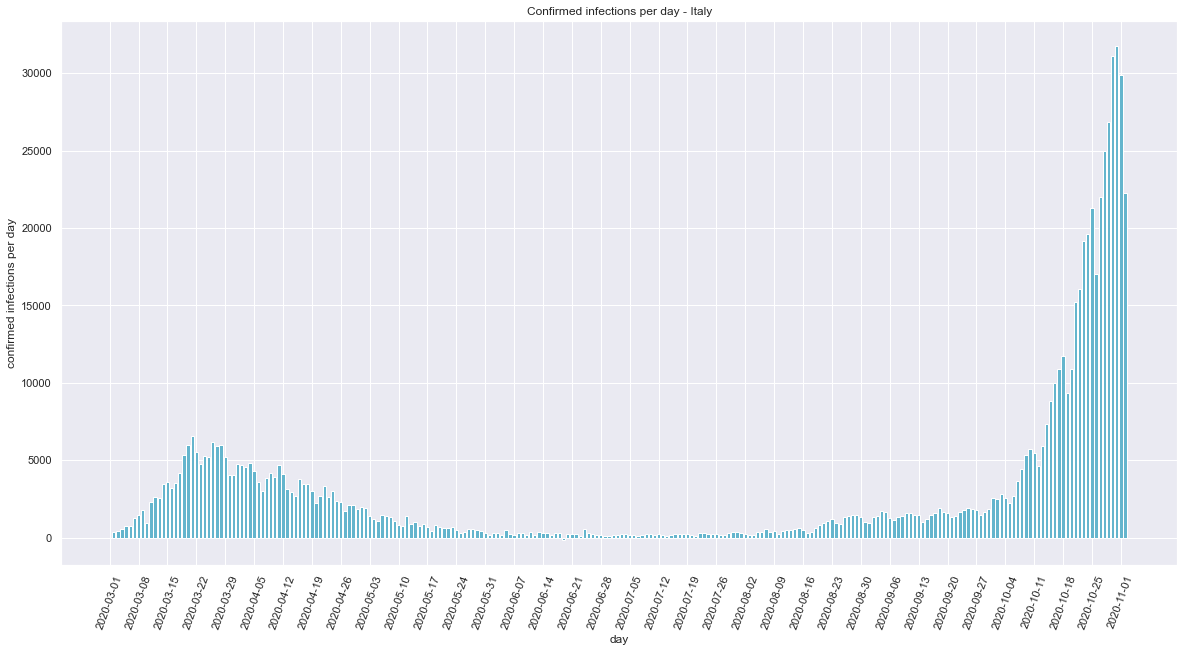

In [5]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax.set_title("Confirmed infections per day - Italy")
ax.set_xlabel("day")
ax.set_ylabel("confirmed infections per day");
ax.set_xticks(week_index)
ax.set_xticklabels(week_index, rotation=70)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.bar(date_index_array[1:], confirmed_per_day_array_it, color='c')
plt.savefig('confirmed-infections-italy.png')

In [6]:
import math
log_confirmed = [math.log(confirmed) for confirmed in confirmed_per_day_array_it[145:]]
len(log_confirmed)

101

In [7]:
import numpy as np
from scipy.optimize import curve_fit

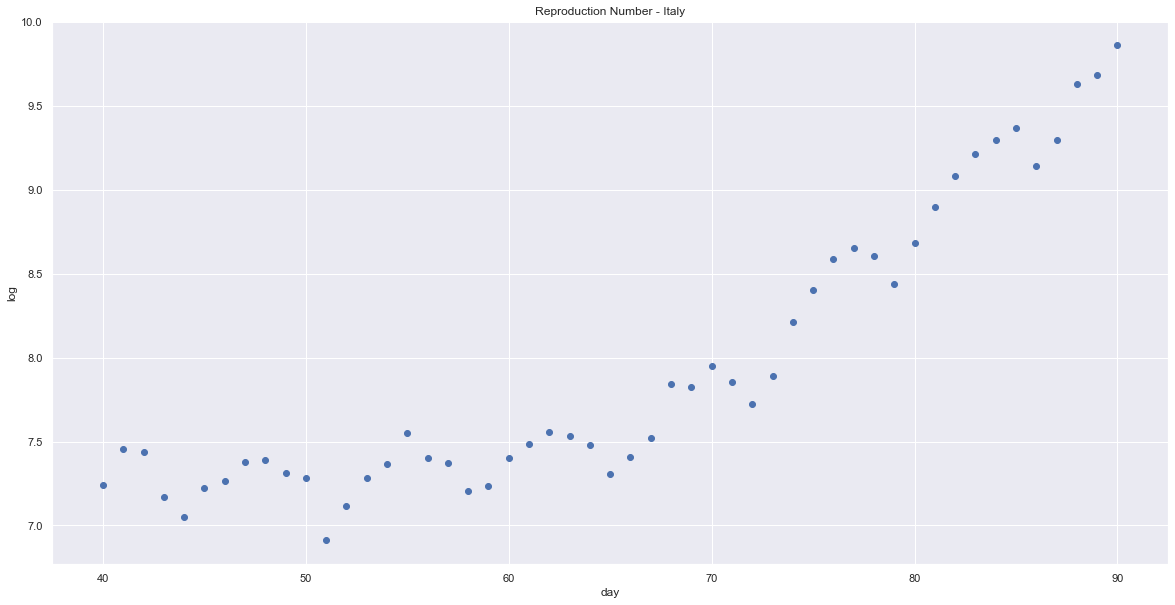

In [8]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax.set_title("Reproduction Number - Italy")
ax.set_xlabel("day")
ax.set_ylabel("log");
x = np.arange(40,91,1)
y = log_confirmed[40:91]
plt.plot(x, y, 'o')

In [9]:
def linearfunc(x, a, b):
    return a * x + b 

In [10]:
popt, pcov = curve_fit(linearfunc, x, y) # estimates the parameters of the linear function a, b
print(popt)

[0.05001181 4.6997198 ]


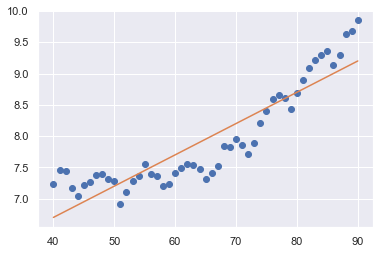

In [11]:
yfit = linearfunc(x,popt[0],popt[1])
plt.plot(x, y, 'o')
plt.plot(x,yfit)